## Chest X-Ray Prediction

### Preparing the Data
- Importing relevant libraries to operate on the data.
- Defining the directories for the data.
- Creating a function to help visualize our model results. 

In [1]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

In [2]:
#Define Directories for train, test & Validation Set
train_path = 'chest_xray/train/'
test_path = 'chest_xray/test/'
valid_path = 'chest_xray/val/'

In [3]:
# Defining results from a visualization function.
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

## Parameters
- The batch refers to the number of training examples utilized in one iteration.
- The dimension of the images we are going to define are 500x500.
- The dimension size of 500 or more with a batch size greater than 16 may result in a crash as the RAM gets completely used in such cases. 
- A lower dimension size with greater batch size is one of the options to try.

In [4]:
# Define some often used standard parameters
batch_size = 16 
img_width = 500
img_height = 500

## Creating an Image Data Generator
- We will increase the size of the image training dataset artificially by performing an Image Augmentation technique. Image Augmentation expands the size of the dataset by creating a modified version of the existing training set images that helps to increase dataset variation and ultimately improve the ability of the model to predict new images.
- The image generator is for:
 1. Train set
 2. Test set

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True)

test_data_gen = ImageDataGenerator(rescale = 1./255)

## Loading up the Images
- The Image Data Generator has a class known as flow from the directory which reads the images from the folders containing the images.
- This will return the DirectoryIterator typetensorflow.python.keras.preprocessing.image.DirectoryIterator.

In [9]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
# Shuffle is set to as False so we can later compare it with predicted values without having indexing problem.
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,  
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Images
- This is a simple preview of some of the train set images obtained from using Data Augmentation.

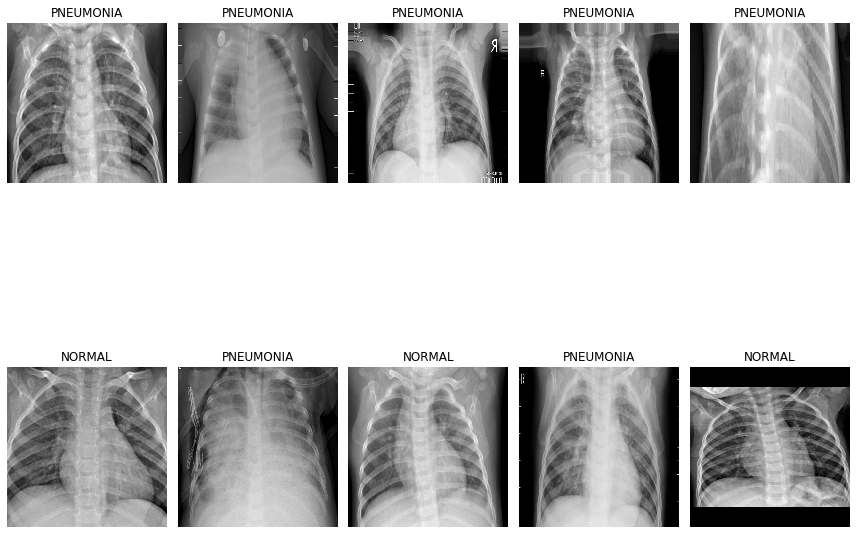

In [10]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

## CNN
- CNN architecture is based on layers of convolution. 
- The convolution layers receive input and transform the data from the image and pass it as input to the next layer. - - The transformation is known as the operation of convolution.
- It is necessary to define the number of filters for each convolution layer. 
- These filters detect patterns such as edges, shapes, curves, objects, textures, or even colors. 
- The more sophisticated patterns or objects it detects are more deeply layered.

In [11]:
# Imports that will allow a CNN architecture to be created.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

### Important things to think about before starting to build a CNN model:
1. Always begin with a lower filter value such as 32 and begin to increase it layer wise.
2. Construct the model with a layer of Conv2D followed by a layer of MaxPooling.
3. The kernel_size is a preferred odd number like 3x3.
4. Tanh, relu, etc. can be used for and activation function, but relu is the most preferred choice.
5. (input_shape) takes three arguments, the images width & height and dimension as color channel.
6. Flatten the input after the CNN layers and then add ANN layers.
7. Use the activation function as softmax for the last layer. If the problem is more than 2 classes, define units as the total number of classes and use sigmoid for binary classification and set unit to 1.

In [12]:
cnn = Sequential()
# Starting out with a lower filter of 32.
# Max Pooling simply says to the Convolutional Neural Network that we will carry forward only that information,
# if that is the largest information available amplitude.
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
# Increasing the filter to 64.
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
# Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
# We flatten the output of the convolutional layers to create a single long feature vector.
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## CNN Summary
- Now that we have developed the model let's see what is going on!

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

## Interpretation of the Model
- Plotting CNN architecture.

In [14]:
# Hyperparameters of Conv2D
Conv2D(filters=2, kernel_size=1,
    strides=(1, 1),
    padding="valid",
    activation=None,
    input_shape=(img_height, img_width, 3)
    )
# Hyperparameters of MaxPooling2D 
MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid"
    )

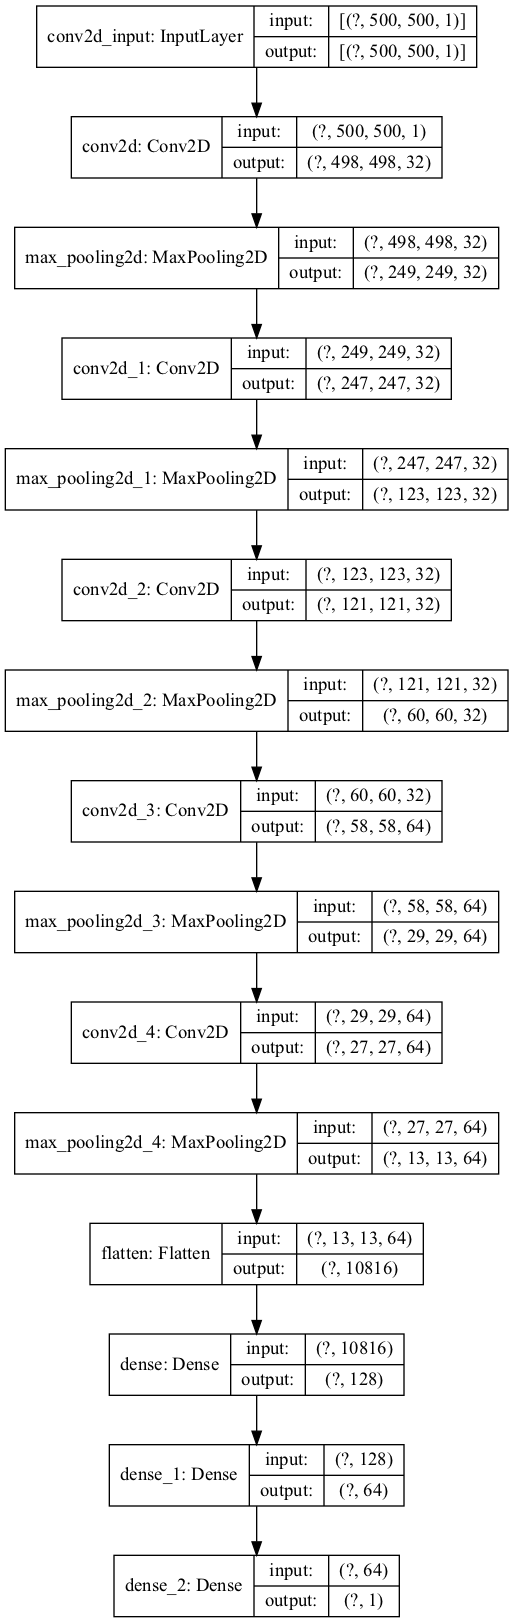

In [15]:
!pip install pydot
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## Fitting the Model
- EarlyStopping is called to stop the epochs based on some metric (monitor) and conditions (mode, patience). 
- It helps to avoid overfitting the model. 
- We are telling the model to stop based on val_loss metric, we need it to be a minimum. 
- (patience) says that after a minimum val_loss is achieved during the next iterations if the val_loss increases in any the 3 iterations then the the training will stop at that epoch.

In [16]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

## Assigning Class Weights
- It is good practice to assign class weights. 
- It emphasizes the weight of the minority class in order for the model to learn from all classes equally.

In [17]:
train.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [18]:
train

In [19]:
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
#cw = dict(zip(np.unique(train.classes), weights))
#print(cw)

In [47]:
#from sklearn.utils import class_weight
#class_weights = dict(zip(np.unique(train), class_weight.compute_class_weight('balanced', np.unique(train), 
                #train))) 

In [23]:
#cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

## Another Way to fit the Model
- Trying a different way to fit the model.

In [57]:
cnn_model = cnn.fit_generator(train,
                         steps_per_epoch=100, validation_steps=500,
                         epochs=1,
                         validation_data = valid)

100/100 [==============================] - 135s 1s/step - loss: 0.2354 - accuracy: 0.9044 - val_loss: 0.8166 - val_accuracy: 0.6250


## Defining the Results of the Visualization Function

Test loss: 0.40600600838661194
Test accuracy: 0.8189102411270142


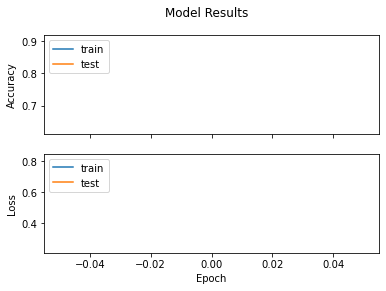

In [58]:
test_accu = cnn.evaluate_generator(test, 500)
#test_accu = cnn.evaluate(test_set, len(validation_generator), verbose=0)
print("Test loss:", test_accu[0])
print("Test accuracy:", test_accu[1])

visualize_training_results(cnn_model)

## Evaluate
- Find the models accuracy.
- Predicting the test dataset.
- Taking a peak at some of the performance measurement metrics in detail to evaluate our model.

In [59]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 12s 313ms/step - loss: 0.4060 - accuracy: 0.8189
The testing accuracy is : 81.89102411270142 %


In [60]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 12s 314ms/step


- The activation function of the last layer is sigmoid.
- This allows the model to give a prediction in the 0 to 1 range and not an exact classification as 0 or 1. 
- So we categorise all the values in the 0.5 to 1 range as 0 and less than 0.5 as 1. 
- Note: 0 denotes a normal case and 1 denotes a case of pneumonia.

In [62]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

## Confusion Matrix
- The upper left (true positive) denotes the number of images correctly predicted as normal cases.
- The bottom right (true negative) denotes the correctly predicted number of images as cases of pneumonia. 
- As Pneumonia case, the upper right denotes the number of incorrectly predicted images but were actually normal cases and the lower left denotes the number of incorrectly predicted Normal case images but were actually Pneumonia case.

<AxesSubplot:>

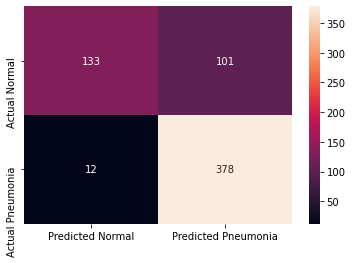

In [63]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

## Classification Report
- Precision = TruePositives / (TruePositives + FalsePositives)
 - The precision score explains how precise/accurate your model is out of those predicted positive. Meaning, how many of them are actually positive.
- Recall = TruePositives / (TruePositives + FalseNegatives)
 - Recall calculates how many of the actual positives our model captured through labeling them as positive (true positive)
- F1 = (2 * Precision * Recall) / (Precision + Recall)
 - F1 Score can be a better measure to use if we need to seek a balance between precision and recall. Especially if there is an uneven class distribution (large number of actual negatives).

In [64]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.92      0.57      0.70       234
   PNEUMONIA       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624



## Visualizing Some of the Predicted Values

In [65]:
# This code extracts the images from the test data iterator without shuffling the sequence.
# x contains image array and y has labels 
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


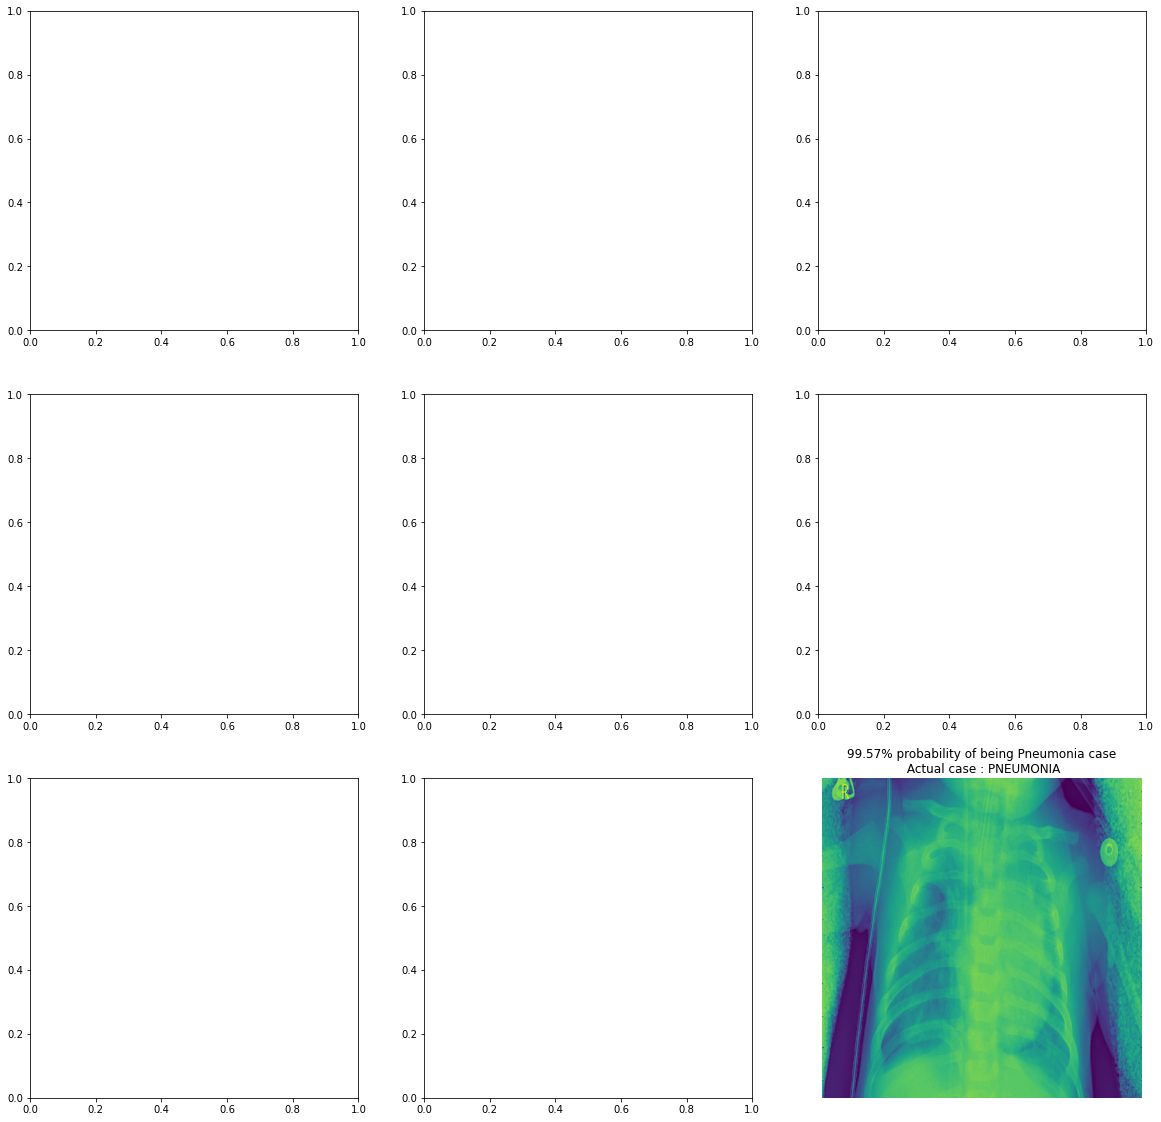

In [66]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
    plt.subplot(3, 3, (i-228)+1)
    if preds[i, 0] >= 0.5: 
        out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
    else: 
        out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()

## Testing on a Random Sample (for fun)
- Picking a random image out.
- Processing the image.
- Predicting from the random image obtained.
- Visualizing the random sample.

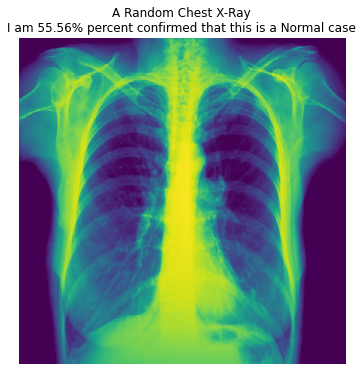

In [67]:
# Testing a random Chest X-Ray from the internet.
random_path = 'chest_xray/X-Ray-Chest-random-32202353-500-400.jpg'
from tensorflow.keras.preprocessing import image
random_img = image.load_img(random_path, target_size=(500, 500), color_mode='grayscale')

# Preprocessing the image.
pp_random_img = image.img_to_array(random_img)
pp_random_img = pp_random_img/255
pp_random_img = np.expand_dims(pp_random_img, axis=0)

# Predicting the accuracy of the random chest x-ray.
random_preds= cnn.predict(pp_random_img)

# Visualize the random sample.
plt.figure(figsize=(6,6))
plt.axis('off')
if random_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(random_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-random_preds[0][0]))
plt.title("A Random Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_random_img))
plt.show()